# 8-Solving Knapsack Problem with PyQUBO

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/ja/008-KnapsackPyqubo.ipynb)

この節では、[Ising formulations of many NP problems](https://arxiv.org/pdf/1302.5843v3.pdf)から、5.2. Knapsack with Integer WeightsをPyQUBOを用いて解く方法について考察します。

## Knapsack問題
Knapsack問題は、具体的には以下のような状況の時にその最適解を求める問題であり、最も有名なNP困難な整数計画問題のひとつとして知られています。まず問題を理解することから始めてみます。

### 具体例

ここでは、分かりやすくするために以下のような物語を考えてみましょう。

> ある探検家がある洞窟を探検していました。
> しばらく洞窟の中を歩いていると、思いがけなく洞窟の中に次のように複数の宝物を見つけました。

<div>
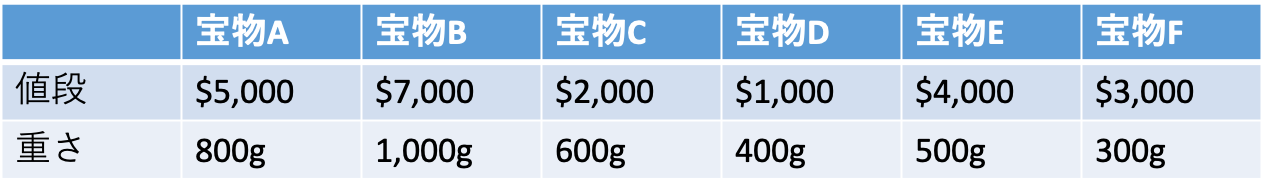
</div>

> しかし、探検家はあいにく手持ちの荷物の中で宝物を運べるような袋として、小さなナップサックしか持っていませんした。

> このナップサックは最大2kgの荷物しか入れることができません。

> 探検家はこのナップサックに入れる荷物をできるだけ高い価値になるようにしたいのですが、どの荷物を選べば最も効率的に宝物を持って帰ることができるでしょうか。

### 問題の一般化

この問題を一般化する際は、ナップサックに入れる荷物$N$個の集合$\{0,1,\cdots,\alpha,\cdots,N-1\}$があり、各荷物が$\alpha$をindexとして持っているものとして考えます。

ナップサック問題では、各荷物$\alpha$のコストのリスト$\mathbf{c}$と重さのリスト$\mathbf{w}$を作ることで問題の初期値を表現することができます。

$$
\mathbf{c}=\{c_0,c_1,\cdots,c_{\alpha},\cdots,c_{N-1}\}
$$

$$
\mathbf{w}=\{w_0,w_1,\cdots,w_{\alpha},\cdots,w_{N-1}\}
$$

ここで、選んだ荷物を表すバイナリ変数$x_{\alpha}$、ナップサックの最大容量$W$、ナップサックに入れた荷物の価格の合計を$C$とします。

すると、以下の式のように選んだ荷物の合計重量$\mathcal{W}$が$W$以下となるような制約条件(制約式(2))を満たしながら、$C$を最大化すること(目的式(1))がナップサック問題の目的となります。

$$
\max C = \sum^{N-1}_{\alpha = 0}c_{\alpha}x_{\alpha} \tag{1}
$$

$$
\mathrm{s.t.}\ \ \mathcal{W} \equiv \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha}  \leq W  \tag{2}
$$

$$
x_{\alpha} \in \{0,1\}  \tag{3}
$$
$$
( \forall \alpha \in \{0,1,2,\cdots,N-1\} )
$$

## QUBO行列への変換方法

QUBO行列では、ペナルティ法として等式しか扱うことができません。そこで、QUBO行列を表現するためには、式(3)で定義したように一般的に使用されるバイナリ変数$x_{\alpha}$に加え、不等式(2)を等式制約にするためのスラック変数$y$を定義します。

ここではまず、スラック変数とは何か、整数をバイナリ変数で表現する方法について説明してから、スラック変数を用いたQUBO行列の生成方法について説明します。

### バイナリ変数による整数表現

#### One-hot encoding



QUBO行列によって整数を表現するためには、バイナリ変数によって整数を表現できるようにしなければなりません。その方法として、One-hot encodingと呼ばれる方法を採用すると、以下のように$1 \leq Y \leq W$を満たす整数$Y$を表現することができます。

$$
Y = \sum^{W}_{i = 1}iy_i \tag{4}
$$

$$
y_i \in \{0,1\}
$$
$$
( \forall i \in \{1,2,3,\cdots,W\} )
$$

One-hot encodingを用いることで、整数$Y$を$W$個のバイナリ変数を用いて定義できることがわかります。

<br><div>
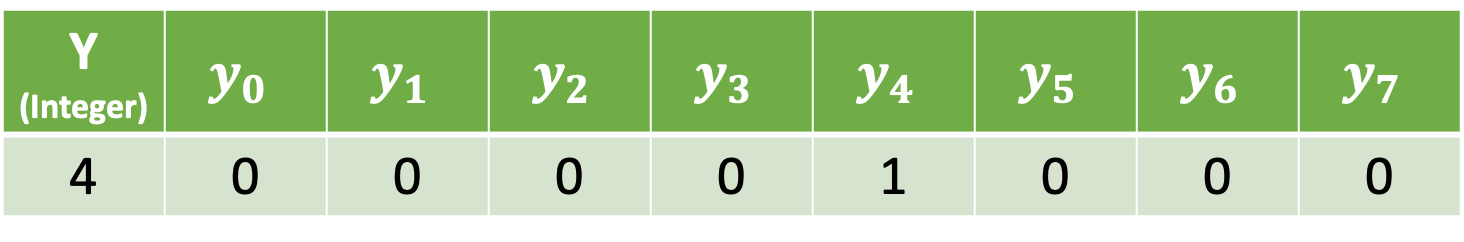
</div>

ただし、整数$Y$に上限値$M$が定められている場合には注意しなければならないことがあります。それは、One-hot encodingにはバイナリ変数のうち、ひとつだけが$y_i=1$でその他が$y_i=0$にならなければならないという制約が必ず必要となることです。

この制約がないと、整数$Y$が上限値$W$よりも大きい数を許すことになってしまいます。

#### Log encoding



上記でOne-hot encodingを用いることで整数$Y$を$W$個のバイナリ変数によって定義できることを示しました。

しかし、バイナリ変数を2進数のように使うことで、整数$X$を$\lfloor \log_2 (W-1)\rfloor + 1$個のバイナリ変数に減らすことができます。これがLog encodingと呼ばれる方法で、以下のように$0 \leq Y \leq W-1$を満たす整数$Y$を表現することができます。

$$
Y = \sum^{\lfloor \log_2 (W-1)\rfloor}_{i = 0} 2^{i}y_i \tag{5}
$$

$$
y_i \in \{0,1\}
$$
$$
( \forall i \in \{0,1,2,\cdots,\lfloor \log_2 (W-1)\rfloor \} )
$$

このように表現することで、例えば$10$という整数であっても$\{y_0,y_1,y_2,y_3\}\{0,1,0,1\}$のように4つのバイナリ変数のみを定義すれば整数$Y$を表現することができるため、特に大規模な問題ではバイナリ変数を大幅に減らすことができることがわかります。

<br><div>
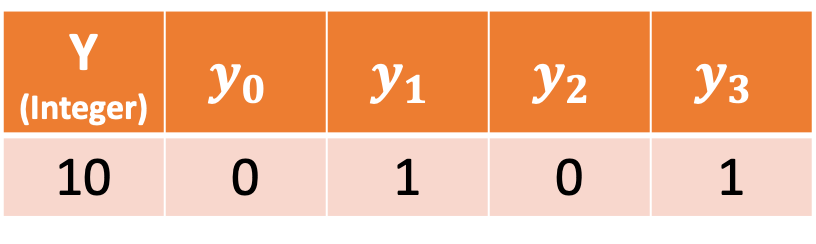
</div>

ただしこのLog encodingでは、表現できる整数の最大値が$2^{\lfloor \log_2 (W-1)\rfloor+1}$となることに気をつける必要があります。

### One-hot encodingにより総重量を表現した制約項(2)の定義

[Ising formulations of many NP problems](https://arxiv.org/pdf/1302.5843v3.pdf)では、One-hot encodingを用いて$1 \leq Y \leq W$を満たす$Y$を以下のように定義し、選択した荷物の合計重量$\mathcal{W}$を表現しています。

$$
\mathcal{W} = Y = \sum^{W}_{n = 1}ny_n \tag{6}
$$

この$Y$を用いることで、荷物の合計重量$\mathcal{W}$との等式を表現することができるようになります。

$$
W \geq \mathcal{W} = Y \tag{7}
$$


$$
\sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} = \sum^{W}_{n = 1}ny_n \tag{8}
$$

$$
0 = \sum^{W}_{n = 1}ny_n - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} \tag{9}
$$

したがって式(9)を満たしたとき、選択する荷物の合計重量がナップサックの最大容量以下でなければならないという制約式(2)を満たしたことと同義になります。そのため、

$$
H_{A1} = A\left(\sum^{W}_{n = 1}ny_n - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha}\right)^2 \tag{9}
$$

とハミルトニアンを定めることで、エネルギーが最小となった際にこの制約を満たすようなスピン状態を得ることができます。

ただし、One-hot encodingではひとつのスピン状態だけが$y_i=1$となり、ほかが$y_i=0$となるようにしなければなりません。したがって、

$$
H_{A0} = A\left( 1 - \sum_{n=1}^{W} y_i \right)^2 \tag{10}
$$

という制約を加えることで、ハミルトニアンの制約項全体$H_A$を定義する必要があります。

$$
H_A=H_{A0}+H_{A1}
$$


$$
H_{A} = A\left( 1 - \sum_{n=1}^{W} y_i \right)^2 + A\left(\sum^{W}_{n = 1}ny_n - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha}\right)^2 \tag{11} 
$$

One-hot encodingを用いた場合、ハミルトニアンは$W$個のスピンによって整数を表現することになります。

#### One-hot encodingを用いた場合の欠点

ハミルトニアンを定義するにあたって、スピンの数が大きくなることは最適化を難しくします。

また、One-hot encodingを用いると、上記のように制約が2つ必要となります。これは一方を満たすと一方を満たさなくなるようなスピン状態を生みやすくなり、制約が冗長であると言わざるを得ません。

しかし、Log encodingを用いることでこれらの問題点を解決することができます。

### Log encodingによるスラック変数を用いた制約項(2)の定義

#### スラック変数

- 参考([数理計画用語集-スラック変数](http://www.msi.co.jp/nuopt/glossary/term_ae6d88ed7539c1112a070758e57339e1cdfa81da.html))

ここで、まずスラック変数について少し説明します。

スラック変数は、不等式制約を等式制約に変換するために用いられる変数のことです。

例えば、$f(x)$が以下のような不等式制約があったとします。

$$
f(x) \leq b \tag{12}
$$

この不等式(4)を等式制約にするためにスラック変数$y \geq 0$を導入すると、以下のように非負制約として書き直すことができます。

$$
f(x) + y = b  
$$
$$
(y \geq 0) \tag{13}
$$

#### Log encodingによるスラック変数を用いる

Log encodingを用いると、 One-hot encodingに比べて少ないバイナリ変数$\lfloor \log_2 (W-1)\rfloor+1$個で整数を表現することができます。

まず、確認として不等式制約は以下の式で表されました。

$$
\mathcal{W} \equiv \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} \leq W \tag{14}
$$

ここで荷物がひとつ以上選択され、総重量が1以上であることを仮定します。すると、スラック変数$Y$を$0\leq Y \leq W-1$を満たすとして定義することができます。

上記不等式はこのスラック変数$Y$を用いると、以下のような等式制約に変換することができることがわかります。

$$
\mathcal{W} + Y = W
$$

$$
0 = W - \mathcal{W} - Y \tag{14}
$$

この等式制約(14)は、先ほどと同様に荷物の合計重量$\mathcal{W}$と$Y$との関係式となっていることがわかります。

ここで、スラック変数$Y$を以下のように具体的にします。

$$
Y \equiv \sum^{\lfloor \log_2 (W-1)\rfloor}_{n = 0} 2^{n}y_n \tag{15}
$$

式()に$\mathcal{W}$と$Y$の定義を代入すると、

$$
0 = W - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} - \sum^{\lfloor \log_2 (W-1)\rfloor}_{n = 0} 2^{n}y_n \tag{16}
$$

のようになります。これを満たすとき、制約式(2)が成り立つことになります。

したがってハミルトニアンによる制約項は、

$$
H_A = A \left( W - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} - \sum^{\lfloor \log_2 (W-1)\rfloor}_{n = 0} 2^{n}y_n \right)^2  \tag{17}
$$

のように書き直すことができます。

#### この方法を用いた際の利点

この方法を用いると、既に述べたようにOne-hot encodingに比べて少ないバイナリ変数$(\lfloor \log_2 (W-1)\rfloor+1)$個で整数を表現することができる以外にも、One-hot encodingのように追加制約を必要としません。

これは、変数$Y$の最大値が$2^{\lfloor \log_2 (W-1)\rfloor+1}$と決まっているからです。

また、確かにLog encodingによって荷物の合計重量を定める際は変数$Y$の最大値が$2^{\lfloor \log_2 (W-1)\rfloor+1}$であることに気をつけなければなりません。

しかし、上記方法ではスラック変数を用いた表現になっているため、荷物の合計重量の最大値が$W$を超えることを心配する必要がありません。

### 目的項(1)の定義

もう一度確認しておくと、目的項(1)はナップサックに入れた荷物の価格の合計を最大化するためのものです。

したがって、ハミルトニアンは単純に以下のように定義すれば、エネルギーが最小となったときのスピン状態は価格の合計を最大化した最適解となるはずです。

$$
H_B = - B\sum^{N-1}_{\alpha = 0} c_{\alpha}x_{\alpha} \tag{18}
$$

ただし、定数A,Bは目的項$H_B$によって制約項$H_A$の制約を違反してはならないので、$0 < B \max(c\alpha) < A$とする必要があります。

## PyQUBOへの実装

### PyQUBOのIntegerクラス

PyQUBOの[Documentation](https://pyqubo.readthedocs.io/en/latest/reference/integer.html)では、バイナリ変数を整数に変換するためのクラスについて説明されています。

Log encodingの整数をそのまま扱うことができる便利なメソッドLogEncIntegerがあるので、今回は上記で定義したスラック変数をこれを用いて定義することとします。

LogEncIntegerの使い方は以下のようになっていて、整数のように使うことができます。

```python
y = LogEncInteger("ラベルの名前", 最小値, 最大値)
```

LogEncInteger()では、最大値upperと最小値lowerを指定しますが、必ずしもupperが最大となることを保証するものではなく、以下の定義を参照してみると、最大値は$2^{\lfloor \log_2 (\mathrm{upper}-\mathrm{lower})\rfloor+1}$となることを理解しておく必要があります。(引用:[Source code for pyqubo.integer.log_encoded_integer](https://pyqubo.readthedocs.io/en/latest/_modules/pyqubo/integer/log_encoded_integer.html#LogEncInteger))

```python
class LogEncInteger(Integer):
    #
    # omission
    #
    def __init__(self, label, lower, upper):
        assert upper > lower, "upper value should be larger than lower value"
        assert isinstance(lower, int)
        assert isinstance(upper, int)

        self.lower = lower
        self.upper = upper
        self._num_variables = int(np.log2(upper - lower))+1
        self.array = Array.create(label, shape=self._num_variables, vartype='BINARY')
        self.label = label
        self._express = lower + sum(x*2**i for i, x in enumerate(self.array))
```

### QUBO行列の生成

ここでは、上記具体例で示した探検家の例を、実際にQUBO行列にしてPyQUBOを用いて解いてみます。

まず、ナップサックの容量と宝物のリストをそれぞれ定義します。

In [3]:
W = 20
c = {0:5, 1:7,  2:2, 3:1, 4:4, 5:3}
w = {0:8, 1:10, 2:6, 3:4, 4:5, 5:3}
N = len(w)

次に、バイナリ変数を定義します。スラック変数yに対しては、先ほどのLogEncInteger()を使います。

In [4]:
from pyqubo import Array, LogEncInteger

x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

これらを用いて、ハミルトニアンをそれぞれ定義します。

$$
H_A = A \left( W - \sum^{N-1}_{\alpha = 0}w_{\alpha}x_{\alpha} - Y \right)^2
$$

$$
H_B = - B\sum^{N-1}_{\alpha = 0} c_{\alpha}x_{\alpha}
$$

スラック変数yはLogEncInteger()を用いると整数と同様に利用することができるので、単純に以下のようになります。ただし、定数A,Bを$0 < B \max(c\alpha) < A$を満たすように先に定義しておきます。

In [5]:
from pyqubo import Constraint

key1 = max(c, key = lambda k: c[k])
B = 40
A = 10 * B * c[key1]

HA = Constraint(
    A * ( W - sum( w[a] * x[a] for a in range(N) ) - y )**2
    , label='HA'
)

HB = - B * sum( c[a] * x[a] for a in range(N) )

### 実行結果

以上の式をPyQUBOに解かせると、次のような結果になります。

In [6]:
from pyqubo import solve_qubo
import dimod
import math

print("[Inputs]")
print()
print("W (ナップサックの容量) : "+str(W/10)+"kg")
print("N (宝物の数): "+str(N))
print()
print("weight list")
print(w)
print()
print("cost list")
print(c)
print()
print("A : "+str(A))
print("B : "+str(B))

H = HA + HB
Q = H
model = Q.compile()
q, offset = model.to_qubo()

sampleset = dimod.ExactSolver().sample_qubo(q)
decoded_sample  = model.decode_sample(sampleset.first.sample, vartype="BINARY")
print()
print("[Results]")
print()
print("decoded_sample.sample:")
print(decoded_sample.sample)
print()
print("x (選ばれた宝物) :")

treasures = ['A','B','C','D','E','F','G']
weight = 0
cost = 0

for k in range(N):
    if decoded_sample.array('x', k) != 0:
        print("宝物"+treasures[k])
        weight += w[k]
        cost += c[k]
    

sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem)) for elem in range(math.ceil(math.log2(W)))])

print()
print("スラック変数Y = {}".format(sol_y))
print()
print("broken")
print(decoded_sample.constraints(only_broken=True))
print("合計の重さ : "+str(weight/10)+"kg")
print("合計の価格 : $"+str(cost)+",000")

[Inputs]

W (ナップサックの容量) : 2.0kg
N (宝物の数): 6

weight list
{0: 8, 1: 10, 2: 6, 3: 4, 4: 5, 5: 3}

cost list
{0: 5, 1: 7, 2: 2, 3: 1, 4: 4, 5: 3}

A : 2800
B : 40

[Results]

decoded_sample.sample:
{'y[4]': 0, 'x[0]': 0, 'x[1]': 1, 'x[2]': 0, 'x[3]': 0, 'x[4]': 1, 'x[5]': 1, 'y[2]': 0, 'y[1]': 1, 'y[0]': 0, 'y[3]': 0}

x (選ばれた宝物) :
宝物B
宝物E
宝物F

スラック変数Y = 2

broken
{}
合計の重さ : 1.8kg
合計の価格 : $14,000


> 結果、宝物B、E、Fをナップサックに入れたとき、重量オーバーにならずかつ最大の合計価格となることがわかりました。

## まとめ

Knapsack問題をQUBO行列に変換して、PyQUBOを用いて解く方法について説明しました。

その際に、整数をバイナリ変数により表現する方法について複数あります。

ここではOne-hot encodingとLog encodingを扱い、Log encodingはスピンを最小限にしながらも余分な制約条件を必要としない点においては優れていることを紹介しました。

それぞれの整数表現について知っておくことで、適材適所で最適な方法を選ぶことができると思います。